<a href="https://colab.research.google.com/github/JoanChege/CHATBOT1/blob/main/ModelFinal7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspellchecker
!pip install contractions
!pip install symspellpy
!pip install nltk contractions pyenchant
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl size=187461 sha256=ea4ce109408de23629edfd22ebba78a4f3320c3a8a9d593511d950c181107502
  Stored in directory: /root/.cache/pip/wheels/88/6a/a6/a1283cc145323a1fb3d475bd158ee60b248ab1985230d266fc
Successfully built editdistpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.7 MB/s eta 0:00:00


In [2]:
#import
import json
import pickle
import numpy as np
import pandas as pd
import contractions
from contractions import contractions_dict
from collections import OrderedDict
import re
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
from wordcloud import STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from gensim.models import Word2Vec


import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.preprocessing.text import tokenizer_from_json

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import gc
gc.collect()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


43

In [3]:
#import data
with open('/content/dataset3.json') as file:
   intents = json.load(file)

In [4]:
# Instantiate spell checker
spell = SpellChecker()

# Stopwords
stop_words = set(stopwords.words('english'))

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

words, documents = [], []

# Extract tags
tags = [intent['tag'] for intent in intents['intents']]
tags = list(set(tags))
tags = sorted(tags)

for intent in intents['intents']:
    for pattern in intent['patterns']:
        # Preprocess text
        pattern = re.sub(r'[^\w\s]', '', pattern)
        pattern = contractions.fix(pattern)
        pattern = pattern.lower()

        # Tokenization
        w_tokens = word_tokenize(pattern)

        # Spell correction
        corrected_words = [spell.correction(word) for word in w_tokens]

        # Filter nones
        corrected_words = [word for word in corrected_words if word]

        # Lemmatization
        lemmed = [lemmatizer.lemmatize(word) for word in corrected_words]

        # Additional preprocessing steps
        lemmed = " ".join([word for word in lemmed if word.lower() not in stop_words])
        lemmed = " ".join([lemmatizer.lemmatize(word) for word in lemmed.split()])
        lemmed = re.sub(r'\d+', '', lemmed)

        words.append(lemmed.split())
        documents.append((lemmed, intent['tag']))

# Create a DataFrame from the documents
df = pd.DataFrame(documents, columns=['processed_text', 'tag'])

# Replace NaN values with the mean of each column
df.fillna(df.mean(numeric_only=True), inplace=True)

# Remove duplicates
words = list(set(word for sublist in words for word in sublist))

# Sort and save the words and tags
# words = sorted(words)
# tags = sorted(tags)

# Save to pickle files
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(tags, open('tags.pkl', 'wb'))

In [5]:
df

,processed_text,tag
0,hi,greeting
1,hey,greeting
2,anyone,greeting
3,hi,greeting
4,hello,greeting
...,...,...
5986,think absolutely need think realized therapy w...,
5987,supposed get head depressed sometimes suicidal...,
5988,med counseling sorted,
5989,deleted,


In [76]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=9401)

# Fit and transform the data to get the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Remove rows with empty strings or whitespaces in the 'target' column
tfidf_df = tfidf_df[tfidf_df['target'].astype(str).str.strip() != '']

# Convert the 'target' column to categorical
tfidf_df['target'] = tfidf_df['target'].astype('category')

# Display the final dataframe
print(tfidf_df.head())

   abandon  abandoned  abandoning  abandonment  abdomen  abduction  abductor  \
0      0.0        0.0         0.0          0.0      0.0        0.0       0.0   
1      0.0        0.0         0.0          0.0      0.0        0.0       0.0   
2      0.0        0.0         0.0          0.0      0.0        0.0       0.0   
3      0.0        0.0         0.0          0.0      0.0        0.0       0.0   
4      0.0        0.0         0.0          0.0      0.0        0.0       0.0   

   abide  ability  able  ...  zelda  zen  zeppelin  zero  zhang  zhou  zip  \
0    0.0      0.0   0.0  ...    0.0  0.0       0.0   0.0    0.0   0.0  0.0   
1    0.0      0.0   0.0  ...    0.0  0.0       0.0   0.0    0.0   0.0  0.0   
2    0.0      0.0   0.0  ...    0.0  0.0       0.0   0.0    0.0   0.0  0.0   
3    0.0      0.0   0.0  ...    0.0  0.0       0.0   0.0    0.0   0.0  0.0   
4    0.0      0.0   0.0  ...    0.0  0.0       0.0   0.0    0.0   0.0  0.0   

   zombie  zone  zoomed  
0     0.0   0.0     0.0 

In [60]:
# Serialize the fitted vectorizer to disk
with open('vectorized.pkl', 'wb') as f:
    pickle.dump(tfidf_df, f)

In [74]:
# Remove rows with empty strings or whitespaces in the 'target' column
tfidf_df = tfidf_df[tfidf_df['target'].astype(str).str.strip() != '']

# Convert the 'target' column to categorical
tfidf_df['target'] = tfidf_df['target'].astype('category')

# Features (X) and Target (y)
X = tfidf_df.drop('target', axis=1)  # Features
y = tfidf_df['target']  # Target

In [75]:
# Print X and y
print("Features (X):")
print(X.head())
print("\nTarget (y):")
print(y.head())

Features (X):
   abandon  abandoned  abandoning  abandonment  abdomen  abduction  abductor  \
0      0.0        0.0         0.0          0.0      0.0        0.0       0.0   
1      0.0        0.0         0.0          0.0      0.0        0.0       0.0   
2      0.0        0.0         0.0          0.0      0.0        0.0       0.0   
3      0.0        0.0         0.0          0.0      0.0        0.0       0.0   
4      0.0        0.0         0.0          0.0      0.0        0.0       0.0   

   abide  ability  able  ...  zelda  zen  zeppelin  zero  zhang  zhou  zip  \
0    0.0      0.0   0.0  ...    0.0  0.0       0.0   0.0    0.0   0.0  0.0   
1    0.0      0.0   0.0  ...    0.0  0.0       0.0   0.0    0.0   0.0  0.0   
2    0.0      0.0   0.0  ...    0.0  0.0       0.0   0.0    0.0   0.0  0.0   
3    0.0      0.0   0.0  ...    0.0  0.0       0.0   0.0    0.0   0.0  0.0   
4    0.0      0.0   0.0  ...    0.0  0.0       0.0   0.0    0.0   0.0  0.0   

   zombie  zone  zoomed  
0     0.0 

<ipython-input-75-4b5144eecba6>:5: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  print(y.head())


In [58]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the sets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (4792, 9400) (4792,)
Validation set: (599, 9400) (599,)
Testing set: (600, 9400) (600,)


In [50]:
# Get the vocab_size and input_length
vocab_size_tfidf = X_train.shape[1]
input_length = vocab_size_tfidf

# Get the number of classes
num_classes = len(np.unique(y_train))

In [51]:
# Create the model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size_tfidf, output_dim=100, input_length=input_length))
model.add(LSTM(units=256, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 9399, 100)         939900    
                                                                 
 lstm_4 (LSTM)               (None, 9399, 256)         365568    
                                                                 
 dropout_6 (Dropout)         (None, 9399, 256)         0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)               

In [21]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Training with early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [23]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels for training set
y_train_encoded = label_encoder.fit_transform(y_train)

# Apply the same transformation to validation and test sets
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert target variables to categorical format
from keras.utils import to_categorical

# Convert the encoded labels to categorical
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)


In [24]:
# Convert X_train to NumPy array
X_train_array = X_train.values

# Ensure y_train_categorical is a NumPy array
y_train_categorical = np.array(y_train_categorical)

# fit the model
model_hist = model.fit(
    X_train_array, y_train_categorical,
    epochs=50,
    batch_size=64,
    validation_data=(X_val.values, np.array(y_val_categorical)),
    callbacks=[early_stop]
)


Epoch 1/50
75/75 [==============================] - 92s 1s/step - loss: 2.3765 - accuracy: 0.9898 - val_loss: 0.4764 - val_accuracy: 1.0000
Epoch 2/50
75/75 [==============================] - 87s 1s/step - loss: 0.2189 - accuracy: 0.9994 - val_loss: 0.0796 - val_accuracy: 1.0000
Epoch 3/50
75/75 [==============================] - 87s 1s/step - loss: 0.0549 - accuracy: 0.9994 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 4/50
75/75 [==============================] - 87s 1s/step - loss: 0.0236 - accuracy: 0.9994 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 5/50
75/75 [==============================] - 87s 1s/step - loss: 0.0144 - accuracy: 0.9994 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 6/50
75/75 [==============================] - 87s 1s/step - loss: 0.0124 - accuracy: 0.9994 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/50
75/75 [==============================] - 86s 1s/step - loss: 0.0116 - accuracy: 0.9994 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 8/50
75/75 [==

In [25]:
model.save("chatbot_model.h5")
print('Done')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


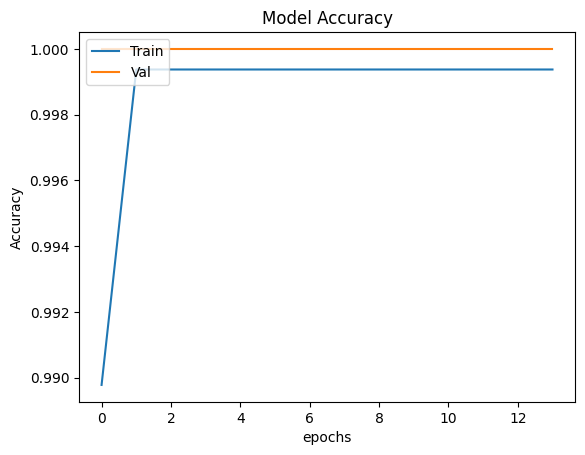

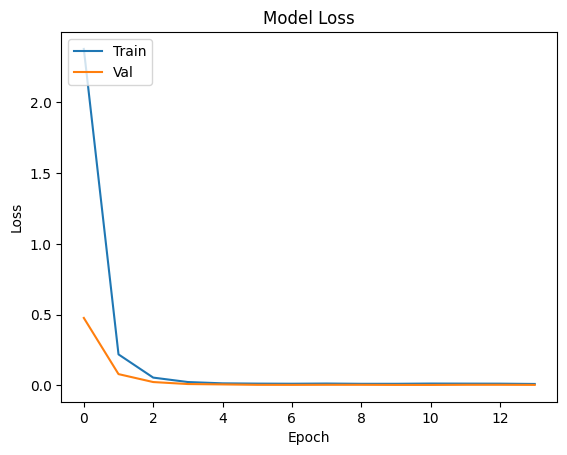

In [26]:
def plot(history):
    #Plot accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot(model_hist)

In [28]:
model.evaluate(X_val.values, y_val_categorical)

19/19 [==============================] - 9s 468ms/step - loss: 0.0034 - accuracy: 1.0000


[0.0034386254847049713, 1.0]

In [30]:
# Convert target variables to categorical format for the test set
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Evaluate the model on the test set
test_metrics = model.evaluate(X_test.values, y_test_categorical)

# Print the test metrics
print("Test Loss:", test_metrics[0])
print("Test Accuracy:", test_metrics[1])



19/19 [==============================] - 8s 417ms/step - loss: 0.0034 - accuracy: 1.0000
Test Loss: 0.003438625717535615
Test Accuracy: 1.0


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Assuming you have predicted probabilities from your model
y_pred_probs = model.predict(X_val.values)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Assuming y_val_classes is the true class labels
y_val_classes = np.argmax(y_val_categorical, axis=1)

# Calculate metrics
acc = accuracy_score(y_val_classes, y_pred_classes)
precision = precision_score(y_val_classes, y_pred_classes, average='weighted')
recall = recall_score(y_val_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')
confusion_mat = confusion_matrix(y_val_classes, y_pred_classes)

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print('Confusion Matrix:')
print(confusion_mat)

# Classification report
print('Classification Report:')
print(classification_report(y_val_classes, y_pred_classes))


19/19 [==============================] - 6s 276ms/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Confusion Matrix:
[[599]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       599

    accuracy                           1.00       599
   macro avg       1.00      1.00      1.00       599
weighted avg       1.00      1.00      1.00       599



In [33]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Assuming you have predicted probabilities from your model
y_pred_probs = model.predict(X_val.values)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Assuming y_val_classes is the true class labels
y_val_classes = np.argmax(y_val_categorical, axis=1)

# Convert class labels to text sequences
reference_sequences = [[str(seq)] for seq in y_val_classes]
predicted_sequences = [str(seq) for seq in y_pred_classes]

# Calculate BLEU score with brevity penalty
bleu_score = corpus_bleu(reference_sequences, predicted_sequences, smoothing_function=SmoothingFunction().method1)

print(f'BLEU Score: {bleu_score:.4f}')


19/19 [==============================] - 6s 319ms/step
BLEU Score: 0.0015


In [41]:
# Load preprocessor dependencies
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()
stop_words = set(stopwords.words('english'))

# Load pretrained vectorizer
vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))

# Preprocess function
def preprocess_user_input(user_input):

    # Preprocess text
    user_input = re.sub(r'[^\w\s]', '', user_input)
    user_input = user_input.lower()

    # Tokenize
    tokens = word_tokenize(user_input)

    # Further preprocessing
    preprocessed = " ".join([lemmatizer.lemmatize(token) for token in tokens if token not in stop_words])

    return preprocessed

# Vectorize input text
def vectorize_input(text):
    vectorized = vectorizer.transform([text])
    return pd.DataFrame(vectorized.toarray(), columns=vectorizer.get_feature_names_out())


print("Ask me anything! [Type QUIT to exit]")

while True:
    user_input = input("> ")

    if user_input.lower() == "quit":
        break

    # Preprocess input
    processed = preprocess_user_input(user_input)

    # Vectorize
    vectorized = vectorize_input(processed)

    # Make prediction, get response, etc.

    print("Ask me another question!")

Ask me anything! [Type QUIT to exit]
> hello
Ask me another question!
> hi
Ask me another question!
> quit


In [44]:
# Check the shape of your vectorized input
print(tfidf_df.shape)


(5991, 9401)


In [53]:
# Load vectorizer
with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

# Load model
model = load_model('chatbot_model.h5')

# Response strings
responses = ["Thanks for your feedback", "I'm glad I could help!", "Good talking to you!"]

def chat():

    while True:
        input_text = input("> ")

        if input_text.lower() == "quit":
            break

        # Vectorize input
        vectorized = vectorizer.transform([input_text])

        # Predict class
        pred = model.predict(vectorized).argmax(axis=1)[0]

        # Print response
        print(responses[pred])

chat()

> hi


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 9400), found shape=(None, 9401)
